Se encontraron 72 archivos


,file,mean,std,min,max
0,Sample_Image_2015-11-27_159.hdf5,93599.997867,13369.081102,75293.0,113008.0
1,Sample_Image_2015-11-27_160.hdf5,92534.432533,13940.058882,73224.0,112266.0
2,Sample_Image_2015-11-27_161.hdf5,93503.821156,13282.563154,75305.0,112768.0
3,Sample_Image_2015-11-27_162.hdf5,92501.441067,13901.262660,73399.0,112271.0
4,Sample_Image_2015-11-27_163.hdf5,93433.300800,13224.325731,75216.0,112445.0


,file,mean,std,min,max,alpha,Ms,Aex
0,Sample_Image_2015-11-27_159.hdf5,93599.997867,13369.081102,75293.0,113008.0,0.856863,0.951749,0.665860
1,Sample_Image_2015-11-27_160.hdf5,92534.432533,13940.058882,73224.0,112266.0,0.893458,0.940914,0.689289
2,Sample_Image_2015-11-27_161.hdf5,93503.821156,13282.563154,75305.0,112768.0,0.851318,0.950771,0.661411
3,Sample_Image_2015-11-27_162.hdf5,92501.441067,13901.262660,73399.0,112271.0,0.890972,0.940579,0.686287
4,Sample_Image_2015-11-27_163.hdf5,93433.300800,13224.325731,75216.0,112445.0,0.847585,0.950054,0.657280


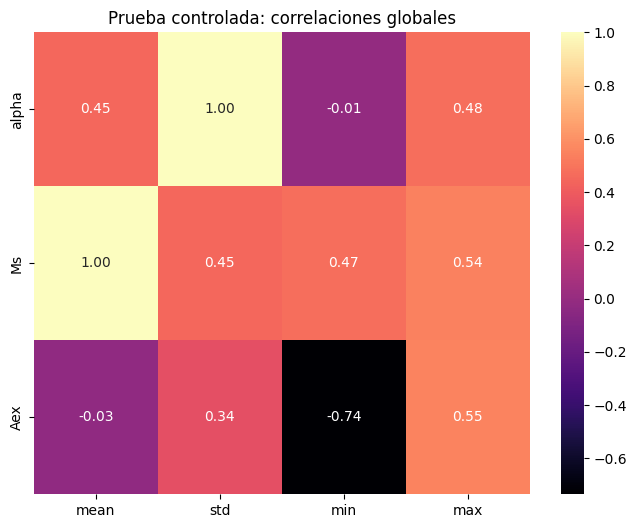

Shape del cubo de imágenes: (72, 75, 75)


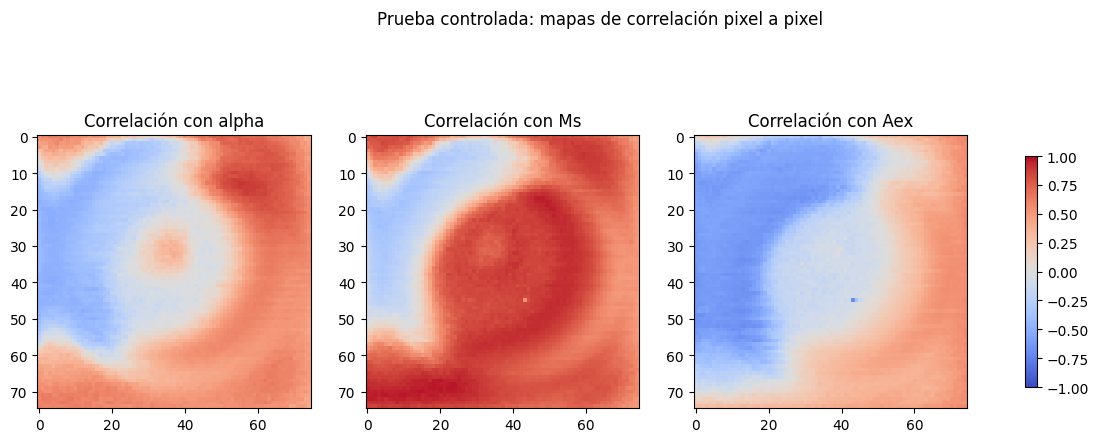

In [1]:
# =============================================
# 05_xmcd_control_test.ipynb
# Validación controlada del pipeline XMCD
# =============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from pathlib import Path

# --- 1. Cargar archivos HDF5 ---
data_path = Path("../data_raw/xmcd")
files = sorted(data_path.glob("*.hdf5"))
print(f"Se encontraron {len(files)} archivos")

def load_hdf5_image(file, key="entry1/analog0/data"):
    with h5py.File(file, "r") as f:
        data = np.array(f[key])
    if data.ndim == 3:
        return data[0]
    return data

# --- 2. Calcular estadísticas globales ---
stats = []
for f in files:
    img = load_hdf5_image(f)
    stats.append({
        "file": f.name,
        "mean": img.mean(),
        "std": img.std(),
        "min": img.min(),
        "max": img.max()
    })

df_stats = pd.DataFrame(stats)
display(df_stats.head())

# --- 3. Crear parámetros simulados dependientes de features ---
# alpha depende de std, Ms de mean, Aex de (max - min)
df_params = pd.DataFrame({
    "file": df_stats["file"],
    "alpha": df_stats["std"] / df_stats["std"].max(),
    "Ms": df_stats["mean"] / df_stats["mean"].max(),
    "Aex": (df_stats["max"] - df_stats["min"]) / (df_stats["max"] - df_stats["min"]).max()
})

# Merge
df_merged = df_stats.merge(df_params, on="file")
display(df_merged.head())

# --- 4. Correlaciones globales ---
corr = df_merged.drop(columns=["file"]).corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr.loc[["alpha","Ms","Aex"], ["mean","std","min","max"]],
            annot=True, cmap="magma", fmt=".2f")
plt.title("Prueba controlada: correlaciones globales")
plt.show()

# --- 5. Mapas pixel a pixel ---
# Generar cubo de datos (n_imágenes, 75, 75)
images = np.array([load_hdf5_image(f) for f in files])
print("Shape del cubo de imágenes:", images.shape)

def pixelwise_corr(images, vector):
    h, w = images.shape[1], images.shape[2]
    corr_map = np.zeros((h,w))
    for i in range(h):
        for j in range(w):
            corr_map[i,j] = np.corrcoef(images[:,i,j], vector)[0,1]
    return corr_map

maps = {
    "alpha": pixelwise_corr(images, df_params["alpha"].values),
    "Ms": pixelwise_corr(images, df_params["Ms"].values),
    "Aex": pixelwise_corr(images, df_params["Aex"].values)
}

fig, axes = plt.subplots(1,3, figsize=(15,5))
for ax, (k, m) in zip(axes, maps.items()):
    im = ax.imshow(m, cmap="coolwarm", vmin=-1, vmax=1)
    ax.set_title(f"Correlación con {k}")
fig.colorbar(im, ax=axes, shrink=0.6)
plt.suptitle("Prueba controlada: mapas de correlación pixel a pixel", y=1.02)
plt.show()


In [ ]:
# --- 6. Guardar resultados en ../figs/control_test/ ---
out_path = Path("../figs/control_test")
out_path.mkdir(parents=True, exist_ok=True)

# Guardar DataFrames
df_stats.to_csv(out_path/"stats.csv", index=False)
df_params.to_csv(out_path/"params.csv", index=False)
df_merged.to_csv(out_path/"merged.csv", index=False)
corr.to_csv(out_path/"correlations.csv")

# Guardar mapas de correlación pixelwise
for k, m in maps.items():
    plt.figure(figsize=(5,4))
    plt.imshow(m, cmap="coolwarm", vmin=-1, vmax=1)
    plt.colorbar(label="Correlación")
    plt.title(f"Mapa de correlación pixelwise con {k}")
    plt.savefig(out_path/f"pixelwise_corr_{k}.png", dpi=150, bbox_inches="tight")
    plt.close()

# Guardar heatmap global
plt.figure(figsize=(8,6))
sns.heatmap(corr.loc[["alpha","Ms","Aex"], ["mean","std","min","max"]],
            annot=True, cmap="magma", fmt=".2f")
plt.title("Prueba controlada: correlaciones globales")
plt.savefig(out_path/"global_corr_heatmap.png", dpi=150, bbox_inches="tight")
plt.close()

print(f"Resultados guardados en {out_path.resolve()}")


✅ Resultados guardados en C:\Users\a.colonia\Documents\tesis-pinn\figs\control_test
